In [1]:
import numpy as np
from hera_cal.io import HERAData, HERACal
import matplotlib.pyplot as plt
%matplotlib notebook

# HERA Data Analysis Part I: Reading, Manipulating, and Visualizing Visibility Data  <a class="tocSkip">

### *Workshop Leaders: Josh Dillon & Aaron Ewall-Wice*  <a class="tocSkip">
#### (Originally developed by Carina Cheng & Josh Dillon)  <a class="tocSkip">

# Reading Files and Metadata

Load HERA data file `zen.2458098.40887.HH.calibrated_downselected.uvh5` (which is in the same folder as this notebook) the `HERAData` object in the `hera_cal.io` module. 

Note `HERAData` objects, [documented here](https://github.com/HERA-Team/hera_cal/blob/d5a08e617865407c7b0eceae03fae63129f2afa3/hera_cal/io.py#L169), are built on top of pyuvdata objects, the HERA collaboration standard data interface. For more, see [the pyuvdata documentation](https://pyuvdata.readthedocs.io/en/latest/).




In [2]:
import numpy as np
from hera_cal.io import HERAData
path = 'zen.2458098.40887.HH.calibrated_downselected.uvh5'
hd = HERAData(path)

This function loads in the metadata of the the data file when it's constructed. So for example, we can answer some questions:

* How many antennas are in the array and what are their antenna numbers? 

* How many frequency channels are there in the array. What range do they cover in MHz?

* How many time integrations are there in the file?


In [3]:
print('There are', len(hd.ants), 'antennas and they are:', hd.ants)

print('\nThere are', len(hd.freqs), 'frequencies, covering a range of',
      np.min(hd.freqs) / 1e6, 'MHz to', np.max(hd.freqs) / 1e6,'MHz.')

print('\nThere are', len(hd.times), 'time integrations.')

There are 52 antennas and they are: [136 140 121  88  41  86  36  51  50  98 123 124  65 137  82 120 143  66
  83 122  67  68  69  70  71  85   0   1  11  12  13  14   2  23  24  25
  26  27  37  38  39  40  52  53  54  55  84  87 141 138 142 139]

There are 1024 frequencies, covering a range of 100.0 MHz to 199.90234375 MHz.

There are 60 time integrations.


## Exercise 1 

Now it's your turn. Try to answer these basic questions about the data:

1. What is the width of each frequency channel in MHz?

2. What range of Julian Dates do they span?

3. What is the lengh of each time integration in seconds?

4. What range of LSTs (local sidreal times) do the data span?

5. How many baselines are in the file? How many should there be? Why don't they agree? Hint: check the `history` attribute of the `HERAData` object.

In [4]:
# your answers here (hint: look at the attributes of the HERAData object)

print('1. The width of each frequency channel is', (hd.freqs[1] - hd.freqs[0]) / 1e6, 'MHz.')

print('\n2. The Julian Dates range from', np.min(hd.times), 'to', np.max(hd.times))

print('\n3. The integration time is', np.median(np.diff(hd.times)) * 24 * 3600, 'seconds.')

print('\n4. The LSTs range from', np.min(hd.lsts)*12/np.pi, 'to', np.max(hd.lsts)*12/np.pi, 'hours.')

print('\n5. There are', len(hd.bls), 'baselines but there should be N*(N-1)/2*4 =', 
      int(len(hd.ants)*(len(hd.ants)-1)/2*4))

print('\n\nHistory of ', path, '\n\n',hd.history)

1. The width of each frequency channel is 0.09765625 MHz.

2. The Julian Dates range from 2458098.408930121 to 2458098.416262386

3. The integration time is 10.737419128417969 seconds.

4. The LSTs range from 4.563460817710191 to 4.739916967508198 hours.

5. There are 6 baselines but there should be N*(N-1)/2*4 = 5304


History of  zen.2458098.40887.HH.calibrated_downselected.uvh5 

 CORR-DACQ: created file.
  Read/written with pyuvdata version: 1.2.1.  Git origin: https://github.com/HERA-Team/pyuvdata.git.  Git hash: 2325220979539b351990bb5916e7dfd7246843c9.  Git branch: h1c.  Git description: v1.2-54-g2325220.  Downselected to specific antennas using pyuvdata. Hera Hex antennas selected with hera_cal/scripts/extract_hh.py, hera_cal version: {'git_hash': '5fb54895439cf3158c47209e2475b32dab67bdc8', 'version': '1.0', 'git_description': 'v1.0-21-g5fb5489', 'git_branch': 'h1c', 'git_origin': 'https://github.com/HERA-Team/hera_cal.git'}.
  Read/written with pyuvdata version: 1.3.7.  Git or

## Exercise 2 

Now let's plot our array to look at where the antennas are. (Hint, use the `hd.antpos` dictionary.)

<IPython.core.display.Javascript object>


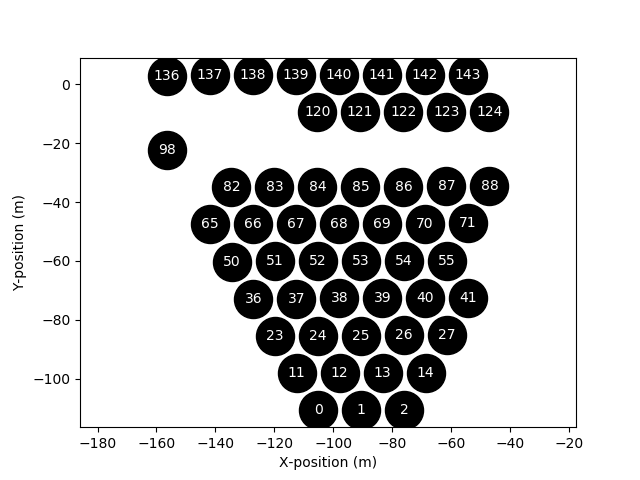

In [5]:
# Fill in the gaps in the code below:

xs = [hd.antpos[ant][0] for ant in hd.ants]
ys = [hd.antpos[ant][1] for ant in hd.ants]

plt.figure()
plt.scatter(xs, ys, marker='.', color='k', s=3000) # plot the antenna positions with black circles
for i, ant in enumerate(hd.ants): # loop over antennas
    plt.text(xs[i], ys[i], ant, color='w', va='center', ha='center') # label antenna numbers
plt.xlabel('X-position (m)')
plt.ylabel('Y-position (m)')
plt.axis('equal');

# Reading Data and Flags

Using a HERAData object, it's very easy to load in data into a convienent format.

In [6]:
data, flags, nsamples = hd.read()

In [7]:
print(type(data))
print(data.keys())

<class 'hera_cal.datacontainer.DataContainer'>
odict_keys([(37, 38, 'xx'), (37, 38, 'yy'), (51, 83, 'xx'), (51, 83, 'yy'), (65, 71, 'xx'), (65, 71, 'yy')])


`data`, `flags`, and `nsamples` are all fancy dictionaries (`DataContainer`s) that give us easy access to data. 

In [8]:
bl = (65, 71, 'xx') # tuple containing baseline and polarization
print(type(data[bl]), data[bl].shape, data[bl].dtype)
print(type(flags[bl]), flags[bl].shape, flags[bl].dtype)

<class 'numpy.ndarray'> (60, 1024) complex128
<class 'numpy.ndarray'> (60, 1024) bool


Now we can start plotting unflagged data. If we divide our data by `~flags`, we treat flags as 1s, so we're dividing flagged data by 0. This is usually bad (don't edit your data with your flags!), but it's useful for visualization.

<IPython.core.display.Javascript object>


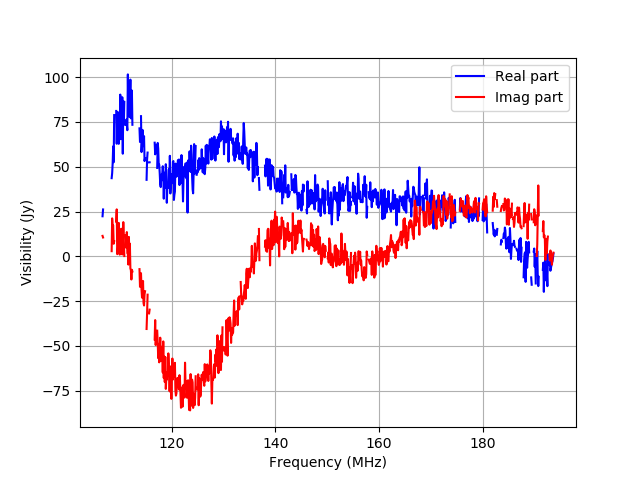

divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


In [9]:
integration = 30 # this is the integration index, 30 out of 60 total integrations
plt.figure()
plt.plot(hd.freqs/1e6, data[bl][integration,:].real / ~flags[bl][integration,:], 'b-', label='Real part')
plt.plot(hd.freqs/1e6, data[bl][integration,:].imag / ~flags[bl][integration,:], 'r-', label='Imag part')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Visibility (Jy)')
plt.grid(); plt.legend();

## Exercise 3
Plot unflagged visibilities as a function of LST for a few different frequency channels. Label each channel's frequency and include a legend.

<IPython.core.display.Javascript object>


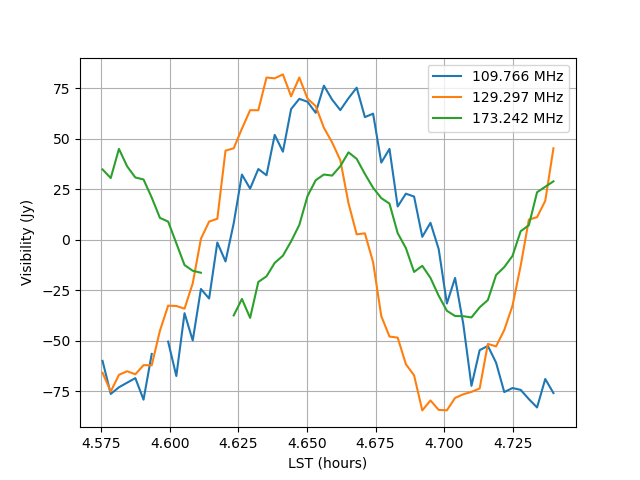

divide by zero encountered in true_divide
Casting complex values to real discards the imaginary part
divide by zero encountered in true_divide
Casting complex values to real discards the imaginary part
divide by zero encountered in true_divide
Casting complex values to real discards the imaginary part


In [10]:
bl = (65, 71, 'xx')
chans = [100,300,750]

# your answer here 
plt.figure()

for chan in chans:
    plt.plot(hd.lsts*24/2/np.pi, data[bl][:,chan] / ~flags[bl][:,chan], 
             label=str(np.round(hd.freqs[chan]/1e6,3)) + ' MHz')
plt.xlabel('LST (hours)')
plt.ylabel('Visibility (Jy)')
plt.grid(); plt.legend();

# Waterfall Plots

Another useful way of visualizing our data is to plot it as a waterfall plot. A waterfall plot is a two-dimensional plot of the visibility (the cross-correlated signal between a pair of antennas) as a function of time (y-axis) and frequency (x-axis). We can use the `plt.imshow` to plot the amplitude and phase of the same baseline as above. Note that the keyword `extent` takes in 4 arguments which define the plot axes extent in the order of (xmin, xmax, ymin, ymax), and we've massaged our axes to display frequencies in MHz and times in LST hours.

<IPython.core.display.Javascript object>


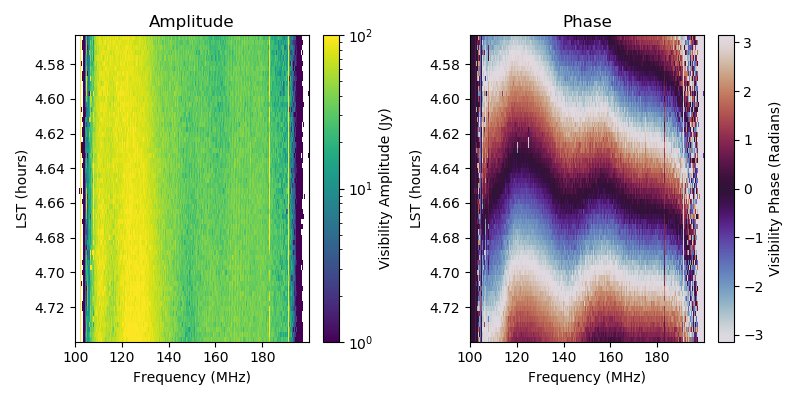

In [11]:
import matplotlib 
bl = (65, 71, 'xx')

# Plot absolute value of visibility
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(np.abs(data[bl]), aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e2),
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Amplitude')

# Plot phase of visibility
plt.subplot(122)
plt.imshow(np.angle(data[bl]), aspect='auto', cmap='twilight',
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Phase')

plt.tight_layout();

Some features to note from the waterfall plots:
* RFI
* Band edges
* Frequency and temporal structure

Thankfully, someone has already done a bunch of work to figure out which data might be bad and flagged it. Here is what the flags look like:

<IPython.core.display.Javascript object>


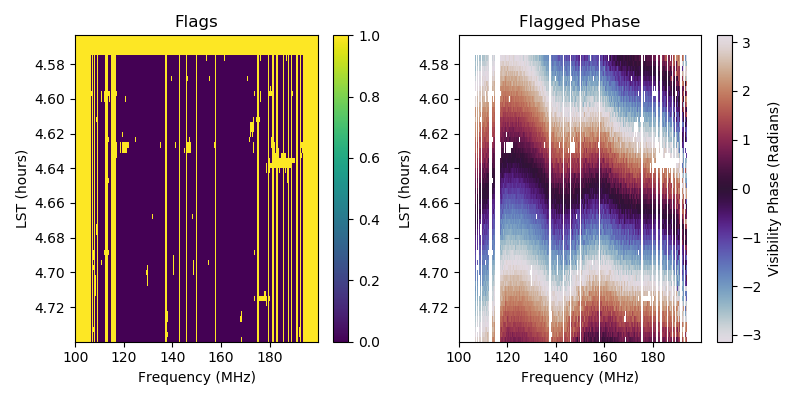

divide by zero encountered in true_divide
invalid value encountered in true_divide


In [12]:
bl = (65, 71, 'xx')

# Plot RFI Flags
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(flags[bl].astype(float), aspect='auto',
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar()
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Flags')

# Plot phase of visibility
plt.subplot(122)
plt.imshow(np.angle(data[bl]) / ~flags[bl], aspect='auto', cmap='twilight',
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Flagged Phase')

plt.tight_layout();

## Exercise 4
Exercise: Now try a short baseline and a long baseline of the same orientation. Make waterfall plots (in both amplitude and phase) for both. How do they differ?

<IPython.core.display.Javascript object>


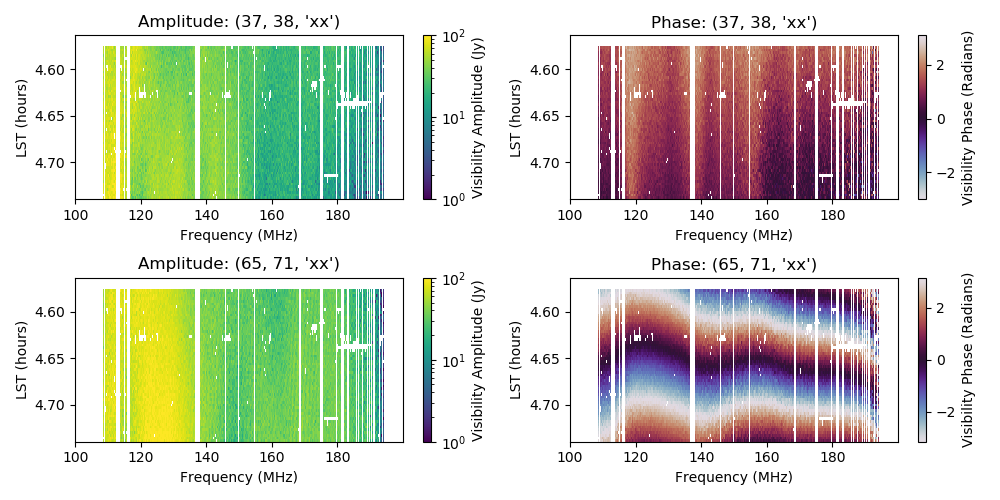

divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


In [13]:
bl1 = (37, 38, 'xx') # short E/W baseline
bl2 = (65, 71, 'xx') # long E/W baseline

# your answer here
plt.figure(figsize=(10,5))
plt.subplot(221)
plt.imshow(np.abs(data[bl1]) / ~flags[bl1], aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e2),
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Amplitude: {}'.format(bl1))

plt.subplot(222)
plt.imshow(np.angle(data[bl1]) / ~flags[bl1], aspect='auto', cmap='twilight',
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Phase: {}'.format(bl1))

plt.subplot(223)
plt.imshow(np.abs(data[bl2]) / ~flags[bl2], aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e2),
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Amplitude: {}'.format(bl2))

plt.subplot(224)
plt.imshow(np.angle(data[bl2]) / ~flags[bl2], aspect='auto', cmap='twilight',
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Phase: {}'.format(bl2))

plt.tight_layout();

## Exercise 5
Now try comparing a N/S baseline to a E/W one of similar lengths do the waterfall plots differ for an E/W baseline vs. a N/S baseline? Does this make sense?

Recall that:

$\LARGE{V_{ij}(\nu) = \int B_{ij}(\mathbf{\hat{r}}, \nu) I(\mathbf{\hat{r}},\nu) e^{-(2 \pi i \nu / c)(\mathbf{b_{ij}}\cdot \mathbf{\hat{r}})}} d\Omega$.

<IPython.core.display.Javascript object>


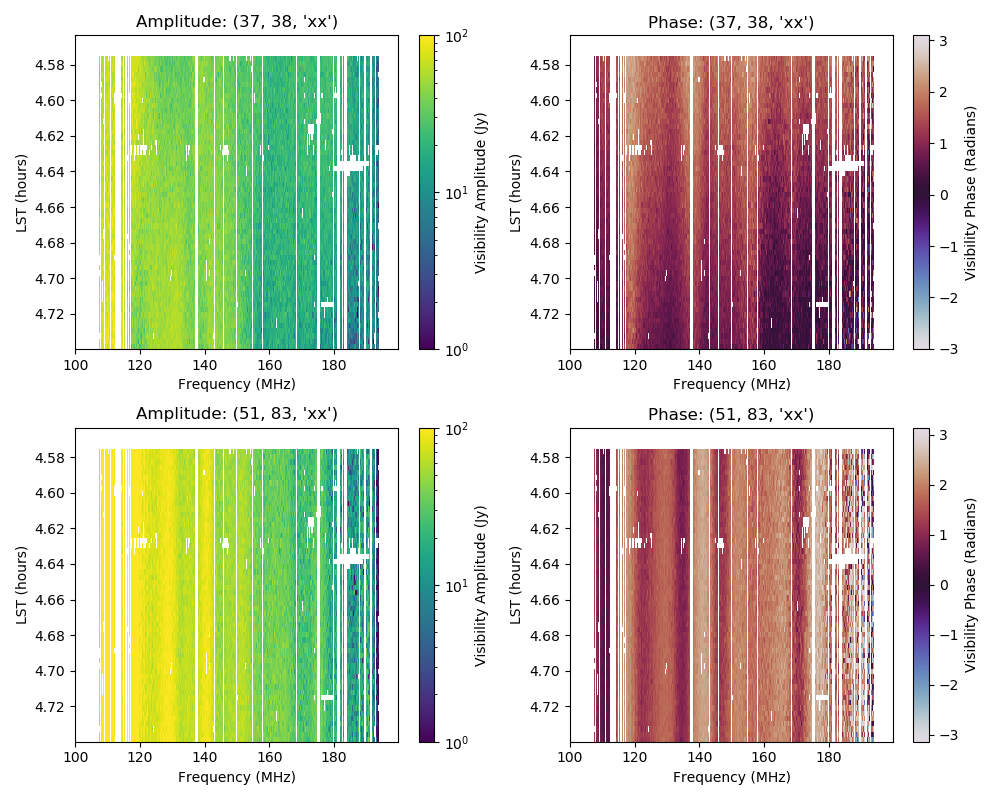

divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide
divide by zero encountered in true_divide
invalid value encountered in true_divide


In [14]:
bl1 = (37, 38, 'xx') # short E/W baseline
bl2 = (51, 83, 'xx') # short N/S baseline

# your answer here
plt.figure(figsize=(10,8))
plt.subplot(221)
plt.imshow(np.abs(data[bl1]) / ~flags[bl1], aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e2),
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Amplitude: {}'.format(bl1))

plt.subplot(222)
plt.imshow(np.angle(data[bl1]) / ~flags[bl1], aspect='auto', cmap='twilight',
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Phase: {}'.format(bl1))

plt.subplot(223)
plt.imshow(np.abs(data[bl2]) / ~flags[bl2], aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e2),
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Amplitude: {}'.format(bl2))

plt.subplot(224)
plt.imshow(np.angle(data[bl2]) / ~flags[bl2], aspect='auto', cmap='twilight',
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Phase: {}'.format(bl2))

plt.tight_layout();

# The Delay Transform

The delay transform is a clever technique we use to isolate bright foregrounds in our data (which we can then filter out). The delay transform is simply the Fourier transform of the visibility along frequency. 

## Exercise 6

Try implementing the delay transform using `np.fft.fft` by following the steps below. We will think about its interpretation after.

<IPython.core.display.Javascript object>


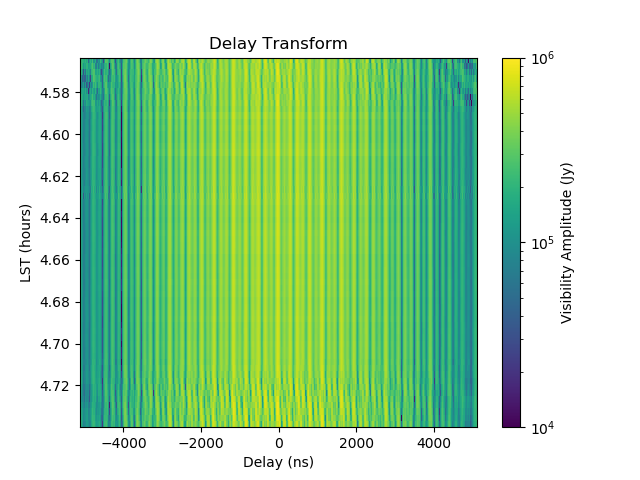

In [15]:
bl = (51,83,'xx')
vis = data[bl]

# 1) Fourier transform "vis" along the frequency axis (don't forget to fftshift after)
#vis_dt = # your answer here 
vis_dt = np.fft.fftshift(np.fft.fft(vis,axis=1), axes=1) # Fourier-transform along frequency

# 2) Find the frequency width of a channel in GHz
#freq_width = # your answer here
freq_width =  np.median(np.diff(hd.freqs)) / 1e9 # GHz

#3) Convert frequencies to delays. Numpy's fftfreq function takes two arguments: 
#   the number of frequencies, and the frequeny width you calculated above
#delays = # your answer here
delays = np.fft.fftshift(np.fft.fftfreq(len(hd.freqs), freq_width)) # ns

import matplotlib
plt.figure()
plt.imshow(np.abs(vis_dt), aspect='auto', norm=matplotlib.colors.LogNorm(1e4,1e6),
           extent=(np.min(delays), np.max(delays),
                   hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Delay (ns)')
plt.ylabel('LST (hours)')
plt.title('Delay Transform');

Yuck! What happened? All that bright RFI - which are very well localized in frequency space - has spread out in delay space, causing that bright interference patten. So let's flag out the RFI!

## Exericse 7

Now plot the delay transform again, but this time set the flagged channels to 0 by multiplying the visibility data by `~flags` (the tilde is to invert the flags, because the saved flags have 1's where the flags are).

<IPython.core.display.Javascript object>


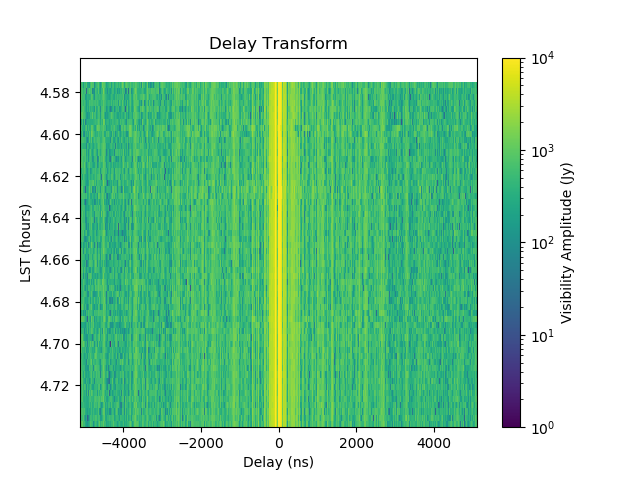

In [16]:
bl = (51,83,'xx')

# your answer here
vis = data[bl] * ~flags[bl] # set flags to 0 (can't divide by 0 or fft will break)
vis_dt = np.fft.fftshift(np.fft.fft(vis,axis=1), axes=1) # Fourier-transform along frequency
freq_width =  np.median(np.diff(hd.freqs)) / 1e9 # GHz
delays = np.fft.fftshift(np.fft.fftfreq(len(hd.freqs), freq_width)) # ns

plt.figure()
plt.imshow(np.abs(vis_dt), aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e4),
           extent=(np.min(delays), np.max(delays),
                   hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Delay (ns)')
plt.ylabel('LST (hours)')
plt.title('Delay Transform');

That's better. So what do we see here? All the bright stuff at low delay values correspond to bright foreground sources that are smooth in frequency (and therefore "peaky" in delay). This is nice for us because we've isolated the foregrounds and we can filter them out easily in this space.

Let's think about what "delay" means physically. A delay can be thought of as the time difference between when a lightwave hits one antenna and when it hits the second antenna. In other words, there is a time lag between light hitting each antenna depending on the direction it comes from and the orientation of the baseline.

Where would the light have to be coming from for the time delay to be zero? Where would it need to be coming from to produce a maximum delay (hint: we call this the horizon limit)?

## Exercise 8
For the baseline we picked earlier, calculate the theoretical maximum delay (in nanoseconds), using $t = d/c$, where $t$ is the time delay, $d$ is the baseline distance, and $c$ is the speed of light. You can calculate the baseline distance using the saved `antpos` and `ants` variables from earlier, or approximate it using the antenna layout plot.

In [17]:
bl = (51,83,'xx')
# your answer here

a1,a2 = bl[0], bl[1] # antennas involved in the baseline
print('Antennas:',a1,a2)

x1, y1, z1 = hd.antpos[a1][0], hd.antpos[a1][1], hd.antpos[a1][2] # x and y coordinate values for the first antenna
x2, y2, z2 = hd.antpos[a2][0], hd.antpos[a2][1], hd.antpos[a2][2] # x and y coordinate values for the second antenna
d = np.sqrt((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2) # baseline distance in meters
print('Baseline length:', d, 'm')

c = 3e8 # speed of light in m/s
t = d/c * 1e9 # time delay in ns
print('Time Delay:', np.round(t), 'ns')

Antennas: 51 83
Baseline length: 25.29501773319829 m
Time Delay: 84.0 ns


A cool trick for a faster calculation is to convert your distance $d$ to feet. That number is also approximately the time delay in nanoseconds! 

Also note that the foregrounds in our delay-transform plot spread out past this horizon limit. This is due to all sorts of effects, but the biggest one is the RFI gaps. However, we have algorithms that can deal with these in a smarter way than just setting them to 0. 

<IPython.core.display.Javascript object>


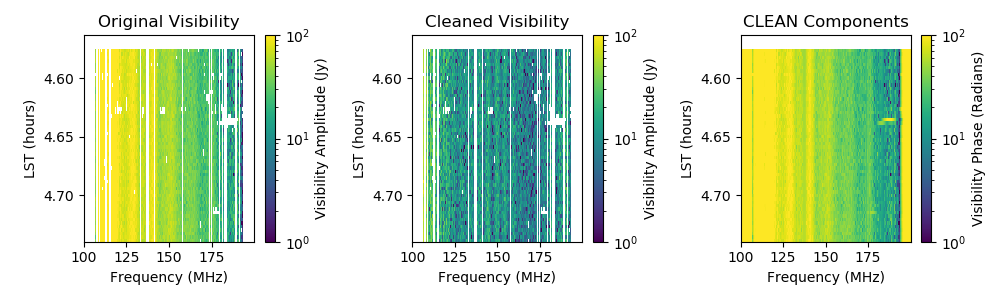

divide by zero encountered in true_divide
invalid value encountered in true_divide


In [18]:
from hera_cal import delay_filter

bl = (51,83,'xx')
df = delay_filter.DelayFilter(hd) # establish delay filter object
df.run_filter(to_filter=[bl]) # filter the specific key we want (otherwise it takes a long time to do all keys)

vis_df = df.clean_resid[bl] # filtered visibility (i.e. the cleaned visibility)
clean = df.clean_data[bl] # low delay modes we don't want (i.e. the stuff that gets filtered out)

# Plot
plt.figure(figsize=(10,3))
plt.subplot(131)
plt.imshow(np.abs(data[bl] / ~flags[bl]), aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e2),
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Original Visibility')

plt.subplot(132)
plt.imshow(np.abs(vis_df), aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e2),
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Cleaned Visibility')

plt.subplot(133)
plt.imshow(np.abs(clean), aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e2),
          extent=(hd.freqs[0]/1e6, hd.freqs[-1]/1e6, 
                  hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('CLEAN Components')

plt.tight_layout();

Comparing the left and middle plots, we see that we've reduced the amplitude of our visibility by a couple orders of magnitude! We also see that some of the foreground structure we see in the left plot has been removed, as the middle plot looks more noise-like. Delay-filtering is a powerful tool for HERA; afterall, we are trying to find a tiny signal (the 21cm EoR signal) buried underneath a lot of stuff we don't care about!

## Exercise 9
Try running the delay filter with `to_filter=[bl]` and `min_dly=6000` to use the CLEAN part of the filter without the "filtering" part. Now image the FFT of `df.clean_data[bl]` in delay vs. LST. How does this compare to what you did above?

<IPython.core.display.Javascript object>


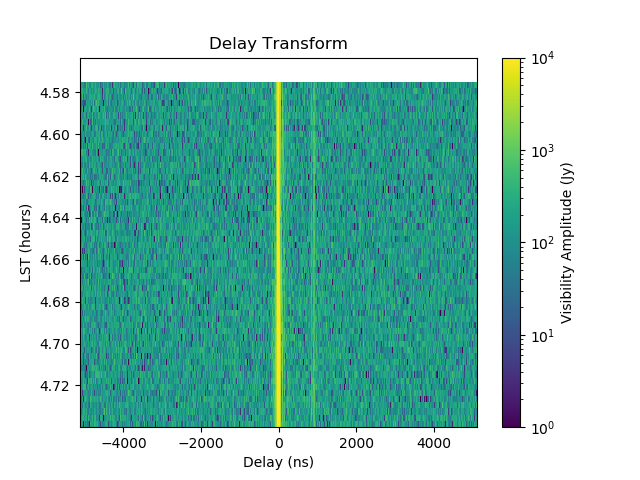

In [19]:
bl = (65,71,'xx')

# your answer here
df = delay_filter.DelayFilter(hd) # establish delay filter object
df.run_filter(to_filter=[bl], min_dly=6000) # try to over all delays

vis = df.clean_data[bl] 
vis_dt = np.fft.fftshift(np.fft.fft(vis, axis=1), axes=1) # Fourier-transform along frequency
freq_width =  np.median(np.diff(hd.freqs)) / 1e9 # GHz
delays = np.fft.fftshift(np.fft.fftfreq(len(hd.freqs), freq_width)) # ns

plt.figure()
plt.imshow(np.abs(vis_dt), aspect='auto', norm=matplotlib.colors.LogNorm(1e0,1e4),
           extent=(np.min(delays), np.max(delays),
                   hd.lsts[-1]*12/np.pi, hd.lsts[0]*12/np.pi))
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Delay (ns)')
plt.ylabel('LST (hours)')
plt.title('Delay Transform');